# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

import optuna

## Functions

In [4]:
def ml_metrics(y_val, y_pred, model_name, k): 
    acc       = mt.accuracy_score(y_val, y_pred)
    precision = mt.precision_score(y_val, y_pred)
    recall    = mt.recall_score(y_val, y_pred)
    f1_score  = mt.f1_score(y_val, y_pred)
    df_results = pd.DataFrame( {'Model':[model_name],
                                'K': [k],
                                'Accuracy': [acc],
                                'Precision': [precision],
                                'Recall': [recall],
                                'F1-Score': [f1_score]})
    
    return df_results

# Carregando Dados

In [5]:
# Dados de Treino
X_train = pd.read_csv('datasets/classificacao/X_training.csv')
y_train = pd.read_csv('datasets/classificacao/y_training.csv').values.ravel()

# Dados de Validação
X_val = pd.read_csv('datasets/classificacao/X_validation.csv')
y_val = pd.read_csv('datasets/classificacao/y_validation.csv').values.ravel()

# Dados de Teste
X_test = pd.read_csv('datasets/classificacao/X_test.csv')
y_test = pd.read_csv('datasets/classificacao/y_test.csv').values.ravel()

In [6]:
print(f'Dados de Treino:    Linhas: {X_train.shape[0]}   Colunas: {X_train.shape[1]}')
print(f'Dados de Validação: Linhas: {X_val.shape[0]}   Colunas: {X_val.shape[1]}')
print(f'Dados de Teste:     Linhas: {X_test.shape[0]}   Colunas: {X_test.shape[1]}')

Dados de Treino:    Linhas: 72515   Colunas: 25
Dados de Validação: Linhas: 31079   Colunas: 25
Dados de Teste:     Linhas: 25893   Colunas: 25


# Ensaio

Métricas do Ensaio:

- Accuracy
- Precision
- Recall
- F1-Score

## Função do Ensaio

In [7]:
# model fine tuning
def ensaio(model, parameters, model_name, n_iter):

    def model_fine_tuning(trial):

        parameters_values = {}

        for name in list(parameters.keys()):
            # dicionário de parametros
            if parameters[name]['type'] == 'int':
                parameters_values[name] = trial.suggest_int(name, parameters[name]['min'], parameters[name]['max'])
            if parameters[name]['type'] == 'float':
                parameters_values[name] = trial.suggest_float(name, parameters[name]['min'], parameters[name]['max'])
            if parameters[name]['type'] == 'str':
                parameters_values[name] = trial.suggest_categorical(name, parameters[name]['values'])

        # definindo modelo
        model.set_params(**parameters_values)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        return np.sqrt(mt.mean_squared_error(y_val, y_pred))
    
    df_results = pd.DataFrame()
    best_params = {}

    # se houve parametros à otimizar
    if len(list(parameters.keys())) > 0:
        # Optuna fine tuning
        model_study = optuna.create_study(direction='minimize')
        model_study.optimize(model_fine_tuning, n_trials=n_iter)

        best_params = model_study.best_params

    # Model fit 
    model.fit(X_train, y_train)

    #### Train
    # Model Predict
    y_pred = model.predict(X_train)
    train_metrics = ml_metrics(y_train, y_pred, model_name, 'Train')

    #### Validation
    # Model Predict
    y_pred = model.predict(X_val)
    validation_metrics = ml_metrics(y_val, y_pred, model_name, 'Validation')

    #### Test
    # Model Predict
    y_pred = model.predict(X_test)
    test_metrics = ml_metrics(y_test, y_pred, model_name, 'Test')

    df_results = pd.concat([df_results, train_metrics], axis=0)
    df_results = pd.concat([df_results, validation_metrics], axis=0)
    df_results = pd.concat([df_results, test_metrics], axis=0)

    return df_results

## Definindo parametros do modelo

In [8]:
knn_parameters = {'n_neighbors':{'type':'int', 'min':2, 'max':20}, 'n_jobs': {'type': 'int', 'min': -1, 'max': -1}}
dt_parameters = {'max_depth':{'type':'int', 'min':2, 'max':50}}
rf_parameters = {'n_estimators':{'type':'int', 'min':2, 'max':50},'max_depth':{'type':'int', 'min':2, 'max':50}}
lr_parameters = {'C':{'type':'float', 'min':0, 'max':10},'max_iter':{'type':'int', 'min':2, 'max':50}, 'solver': {'type': 'str', 'values':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}}

## Definindo parametros do ensaio

In [ ]:
dict_models = {
    'KNN':{'model': KNeighborsClassifier(), 'parameters': knn_parameters},
    'Logistic Regression': {'model': LogisticRegression(), 'parameters': lr_parameters},
    'Decision Tree': {'model': DecisionTreeClassifier(), 'parameters': dt_parameters},
    'Random Forest': {'model': RandomForestClassifier(), 'parameters': rf_parameters}
}

## Ensaiando Modelos

In [9]:
df_results = pd.DataFrame()
for i_model in list(dict_models.keys()):
    model_name = i_model
    model = dict_models[i_model]['model']
    model_params = dict_models[i_model]['parameters']
    print(f'{model_name}')
    
    i_results = ensaio(model, model_params, model_name, 100)
    
    df_results = pd.concat([df_results, i_results], axis=0)
df_results

# Resultados Finais

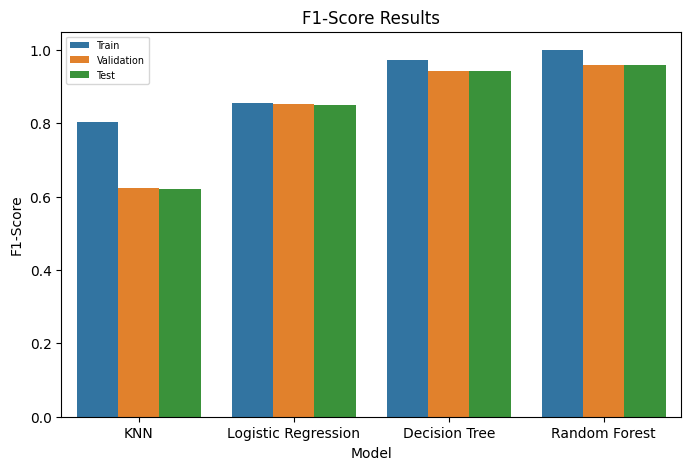

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1-Score', hue = 'K', data=df_results)
plt.title('F1-Score Results')
plt.legend(fontsize='x-small', title_fontsize='10');